<a href="https://colab.research.google.com/github/konstantin1998/first-repository/blob/master/litpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import torchsummary

from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import PIL
import cv2
import pandas as pd
%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

class DataGenerator():
  def __init__(self, train_dir, test_dir, results_file):
    self.train_dir = train_dir
    self.test_dir = test_dir
    results_df = pd.read_csv(results_file)
    self.results = pd.Series(results_df['score'].values, index=results_df['name'].values)
  
  def get_quality(self, img_path):
    dir, name = os.path.split(img_path)
    quality = self.results[name]
    return quality

  def load_sample(self, path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape((1, *img.shape)).astype('float32')
    tensor = torch.from_numpy(img)
    return tensor
  
  def assign_qualities(self, dataset):
    items = []
    for sample in dataset.samples:
      path, label = sample
      quality = self.get_quality(path) 
      sample = (path, float(quality))
      items.append(sample)
    dataset.samples = items

  def prepare_data(self):
    trainset = torchvision.datasets.ImageFolder(
      root=self.train_dir,
      loader=self.load_sample
    )
    self.assign_qualities(trainset)
    trainloader = torch.utils.data.DataLoader(
      trainset,
      batch_size=12,
      shuffle=False,
      num_workers=2
    )

    testset = torchvision.datasets.ImageFolder(
      root=self.test_dir,
      loader=self.load_sample
    )
    self.assign_qualities(testset)
    testloader = torch.utils.data.DataLoader(
      testset,
      batch_size=4,
      shuffle=False, 
      num_workers=2
    )

    return trainloader, testloader



In [ ]:
data_generator = DataGenerator('/content/drive/My Drive/Pictures/cropped_old/train',
                               '/content/drive/My Drive/Pictures/cropped_old/test',
                               '/content/drive/My Drive/Pictures/cropped_old/results.csv')
trainloader, testloader = data_generator.prepare_data()

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 10, 4),
        nn.BatchNorm2d(10),
        nn.ReLU(),
        nn.MaxPool2d(4)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(10, 5, 4),
        nn.BatchNorm2d(5),
        nn.ReLU(),
        nn.MaxPool2d(4)
    )    
    
    self.fc = nn.Linear(5*244*106, 1)
      
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    #x = self.conv3(x)

    x = x.view(x.size(0), -1)   
    x = self.fc(x)
    return x


In [ ]:
def train(model, optim, criterion, dataloader, epoch, device):
    total = 0
    train_loss = 0
    
    model.train()
    for data, label in dataloader:
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data)
        output = output.reshape((output.shape[0])).float()
        label = label.float()
        
        
        loss = criterion(output, label)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        total += output.shape[0]
        
    return train_loss / total

In [ ]:
def test(model, criterion, dataloader, epoch, device, model_name='model'):
    total = 0
    test_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            output = output.reshape((output.shape[0])).float()
            label = label.float()

           

            loss = criterion(output, label)
            test_loss += loss
            total += data.shape[0]
    
    return test_loss / total

In [ ]:
torch.manual_seed(1)
model = Model()
torchsummary.summary(model.cuda(), (1, 3933, 1724))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 10, 3930, 1721]             170
       BatchNorm2d-2       [-1, 10, 3930, 1721]              20
              ReLU-3       [-1, 10, 3930, 1721]               0
         MaxPool2d-4         [-1, 10, 982, 430]               0
            Conv2d-5          [-1, 5, 979, 427]             805
       BatchNorm2d-6          [-1, 5, 979, 427]              10
              ReLU-7          [-1, 5, 979, 427]               0
         MaxPool2d-8          [-1, 5, 244, 106]               0
            Linear-9                    [-1, 1]         129,321
Total params: 130,326
Trainable params: 130,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 25.87
Forward/backward pass size (MB): 1629.09
Params size (MB): 0.50
Estimated Total Size (MB): 1655.45
------------------------------------

In [ ]:
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

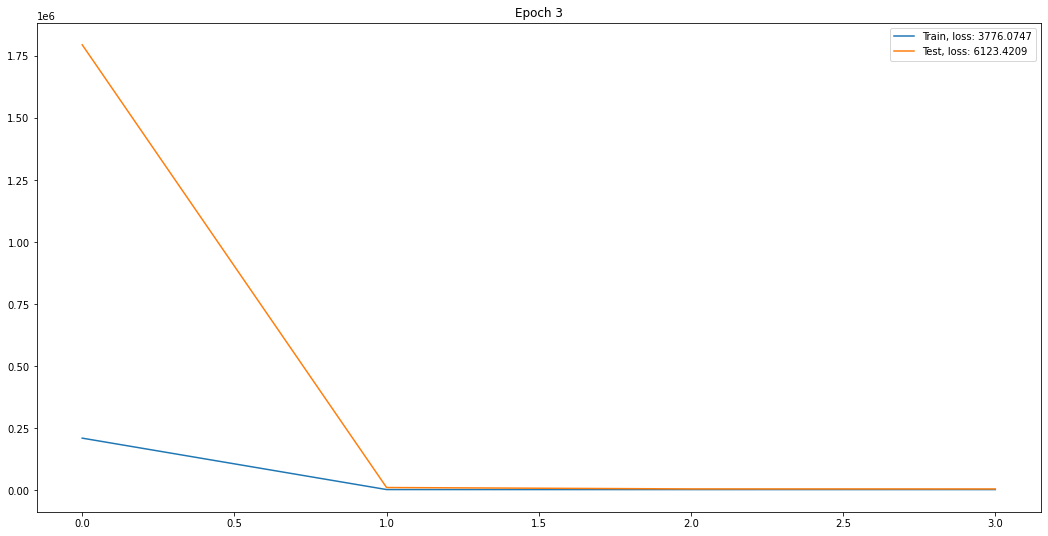

test losses: [tensor(1794018.8750, device='cuda:0'), tensor(11977.8281, device='cuda:0'), tensor(6337.3696, device='cuda:0'), tensor(6123.4209, device='cuda:0')]


In [ ]:
train_losses = []
test_losses = []

best_loss = 20700
num_epochs = 4
for i in range(num_epochs):
    train_loss = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss = test(model, criterion, testloader, i, device)
    scheduler.step(test_loss) 
    test_losses.append(test_loss)
      
    if test_loss < best_loss:
        print('Saving..')
        best_loss = test_loss
        torch.save(model, '/content/drive/My Drive/Pictures/cropped_old/models/ckpt31.07.21.29.pth')

    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

print('test losses:', test_losses)
    